# Kaggle News Impact Analysis (based on a regressor trained on domain adapted UCI Online News Popularity Dataset)

In this notebook, we analyze the distribution differences between the Kaggle Fake News dataset and the UCI Online News Popularity Dataset. We account for the differences through outlier removal and a domain adaptation technique where we reweight the source instances based on a ratio of source and target domain probability.

Here, the source domain is the UCI Online News Popularity dataset and the target domain is the Kaggle Fake News Dataset. We have extracted features from the Kaggle Fake News Dataset, with respect to the UCI Online News Popularity dataset. The extracted features are a subset of the feature space of the UCI Online News Popularity dataset. We have felt that the following features from the UCI dataset could be feasibly extracted from the Kaggle dataset. So, we followed the feature guideline from the original paper [[1]](#1-paper) and extracted the following features from the Kaggle dataset.

1. n_tokens_title
2. n_tokens_content
3. n_unique_tokens
4. n_non_stop_words
5. n_non_stop_unique_tokens
6. average_token_length
7. global_subjectivity: Text subjectivity
8. global_sentiment_polarity: Text sentiment polarity
9. global_rate_positive_words: Rate of positive words in the content
10. global_rate_negative_words: Rate of negative words in the content
11. rate_positive_words: Rate of positive words among non-neutral tokens
12. rate_negative_words: Rate of negative words among non-neutral tokens
13. avg_positive_polarity: Avg. polarity of positive words
14. min_positive_polarity: Min. polarity of positive words
15. max_positive_polarity: Max. polarity of positive words
16. avg_negative_polarity: Avg. polarity of negative words
17. min_negative_polarity: Min. polarity of negative words
18. max_negative_polarity: Max. polarity of negative words
19. title_subjectivity: Title subjectivity
20. title_sentiment_polarity: Title polarity

Although extracting the following features (native to UCI dataset) from Kaggle dataset was not feasible, we have felt that these features could be easily taken as input from a user to analyze the impact of a news. These features are as follows:

1. num_imgs
2. num_videos
3. is_weekday_monday (day on which news will be published)
4. is_weekday_tuesday
5. is_weekday_wednesday
6. is_weekday_thursday
7. is_weekday_friday
8. is_weekday_saturday
9. is_weekday_sunday

In [259]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 4000
pd.options.display.max_rows = 4000

from termcolor import colored

from scipy.spatial import distance

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#### Reading UCI Online News Popularity Dataset

In [294]:
data_uci = pd.read_csv('../data/external/OnlineNewsPopularity/archive/OnlineNewsPopularity.csv')

In [295]:
data_uci.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [296]:
col_list_to_category = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                        'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']

data_uci[col_list_to_category] = data_uci[col_list_to_category].astype('category')

In [297]:
col_list_to_drop = ['url', 'timedelta', 'is_weekend',
                    'data_channel_is_lifestyle', ' data_channel_is_entertainment',
                    'data_channel_is_bus', 'data_channel_is_socmed',
                    'data_channel_is_tech', 'data_channel_is_world',
                    'kw_min_min', 'kw_max_min', 'kw_avg_min',
                    'kw_min_max', 'kw_max_max', 'kw_avg_max',
                    'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
                    'num_hrefs', 'num_self_hrefs', 'num_keywords',
                    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess',
                    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
                    'abs_title_subjectivity', 'abs_title_sentiment_polarity']

col_set_to_drop = set(col_list_to_drop)
col_set_to_drop.intersection_update(set(data_uci.columns))

if(col_set_to_drop):
    col_list_to_drop = list(col_set_to_drop)
    
    data_uci = data_uci.drop(col_list_to_drop, axis=1)

reordered_cols = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
                   'n_non_stop_words', 'n_non_stop_unique_tokens', 'average_token_length',
                   'global_subjectivity', 'global_sentiment_polarity',
                   'global_rate_positive_words', 'global_rate_negative_words',
                   'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
                   'min_positive_polarity', 'max_positive_polarity',
                   'avg_negative_polarity', 'min_negative_polarity',
                   'max_negative_polarity', 'title_subjectivity',
                   'title_sentiment_polarity', 'num_imgs', 'num_videos', 'weekday_is_monday',
                   'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                   'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'shares']

data_uci = data_uci[reordered_cols]

data_uci.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,num_imgs,num_videos,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.680365,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,593
1,9.0,255.0,0.604743,1.0,0.791946,4.913725,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2,9.0,211.0,0.575130,1.0,0.663866,4.393365,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1500
3,9.0,531.0,0.503788,1.0,0.665635,4.404896,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1200
4,13.0,1072.0,0.415646,1.0,0.540890,4.682836,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,505


In [298]:
def print_plot_distribution(var):
    shares_range = max(var) - min(var)

    x = []
    y = []
    bins = 10

    for i in range(1, bins+1):
        lower_range = shares_range * (i-1)/bins
        upper_range = shares_range * (i)/bins

        counter = len(data[(var > lower_range) & (var <= upper_range)])

        x.append(i)
        y.append(counter)

    plt.bar(x, y)

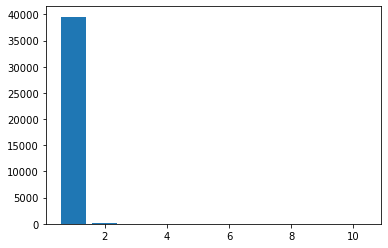

In [299]:
print_plot_distribution(data_uci['shares'])

The above visualization of the target variable's (shares) distribution shows us that the output variable is skewed to the left. We apply log transformation to remove the skewness and have the target feature lean towards a normal distribution.

In [300]:
log_shares = np.log(data_uci['shares'] + 0.0001)

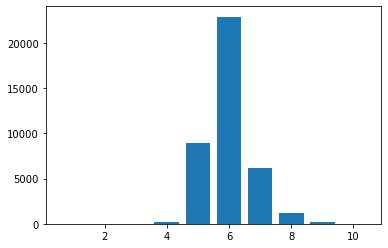

In [301]:
print_plot_distribution(log_shares)

The log transformed target variable's (shares) distribution has become rather normal than it was before. So, we will apply a log transformation on the y_train variable after we split the data into train and test samples.

In [302]:
col_list_to_scale = ['n_tokens_title', 'n_tokens_content', 'num_imgs', 'num_videos', 'average_token_length']

scaler = StandardScaler()

data_uci[col_list_to_scale] = scaler.fit_transform(data_uci[col_list_to_scale])

***
### Reading Kaggle News Extracted Feature (for testing)

In [303]:
data_kaggle_features = pd.read_csv('../data/processed/kaggle_features/kaggle_features1.csv', index_col=['id'])
data_kaggle_features.dropna(inplace=True)

In [304]:
data_kaggle_features.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity
id,,,,,,,,,,,,,,,,,,,,
0,2.833213,6.742881,0.426887,0.520047,0.338443,8.289037,0.482216,0.006777,0.024764,0.020047,0.552632,0.447368,0.291412,0.050000,0.70,-0.409314,-0.050000,-1.000000,0.000000,0.000000
1,2.197225,6.561031,0.521924,0.534653,0.417256,8.106515,0.495110,0.100880,0.032532,0.018388,0.638889,0.361111,0.365758,0.062500,0.80,-0.239744,-0.050000,-0.666667,0.100000,0.000000
2,2.079442,7.150701,0.443922,0.549804,0.381961,8.728426,0.405107,0.056258,0.032157,0.018039,0.640625,0.359375,0.323984,0.033333,0.60,-0.273973,-0.050000,-0.700000,0.000000,0.000000
3,2.397895,6.331502,0.444840,0.565836,0.352313,7.864804,0.262625,0.017497,0.021352,0.033808,0.387097,0.612903,0.348611,0.100000,0.55,-0.172682,-0.071429,-0.300000,0.107143,-0.135714
4,2.708050,5.030438,0.640523,0.581699,0.470588,6.626718,0.112500,-0.012500,0.000000,0.006536,0.000000,1.000000,0.000000,0.000000,0.00,-0.050000,-0.050000,-0.050000,0.250000,0.000000


In [305]:
col_list_to_scale = ['n_tokens_title', 'n_tokens_content', 'average_token_length']

scaler = StandardScaler()

data_kaggle_features[col_list_to_scale] = scaler.fit_transform(data_kaggle_features[col_list_to_scale])

***
## Observing the distributions of the common feature subset between the following datasets

1. **Left column (source domain)**  - UCI Online News Popularity dataset
1. **Right column (target domain)** - Extracted common features from Kaggle Fake News Dataset

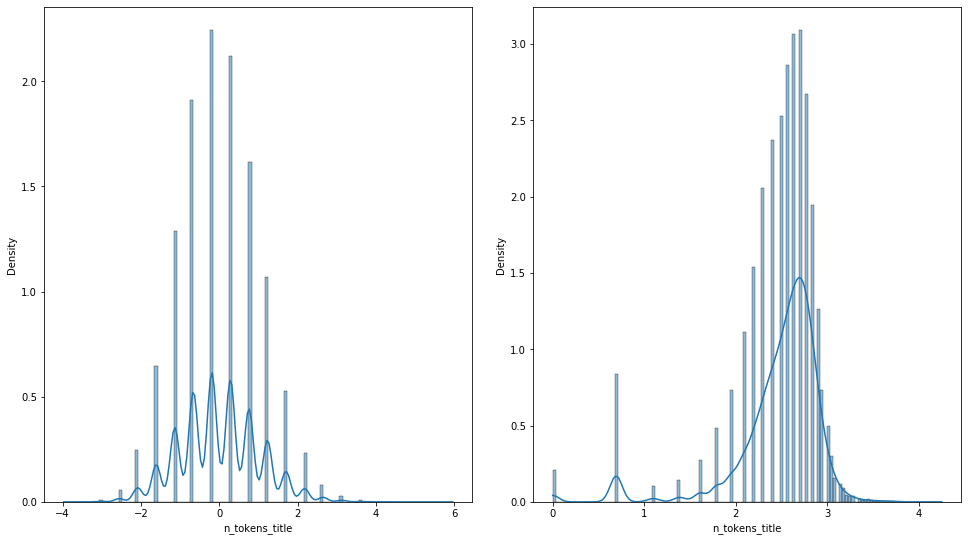

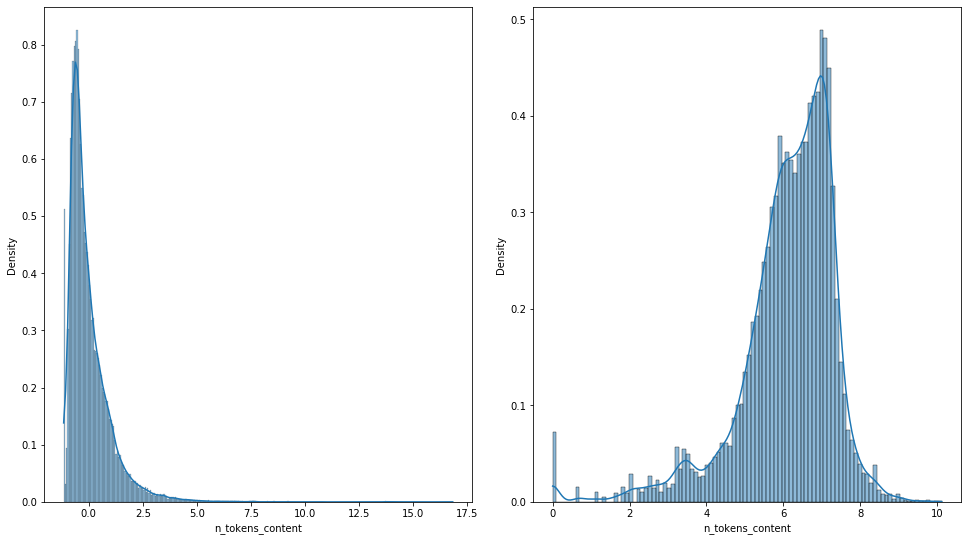

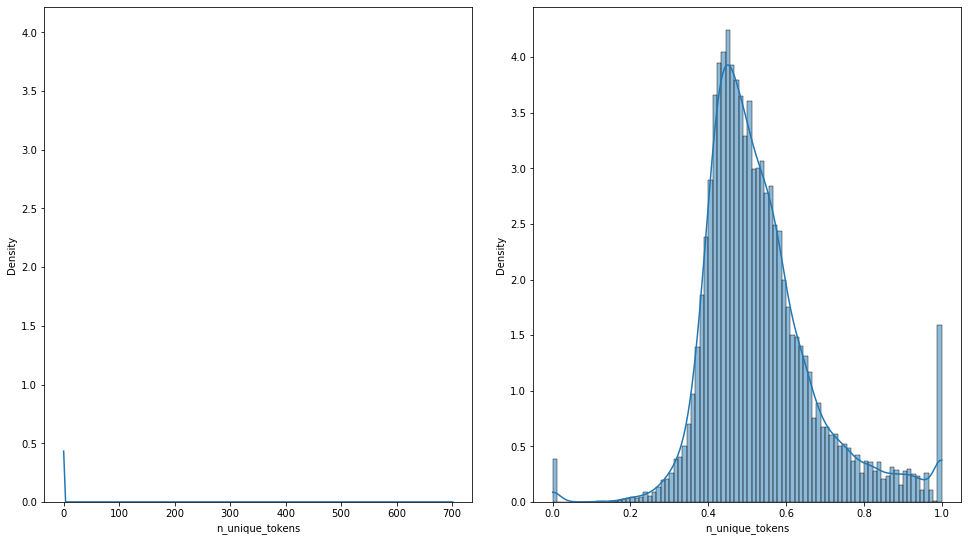

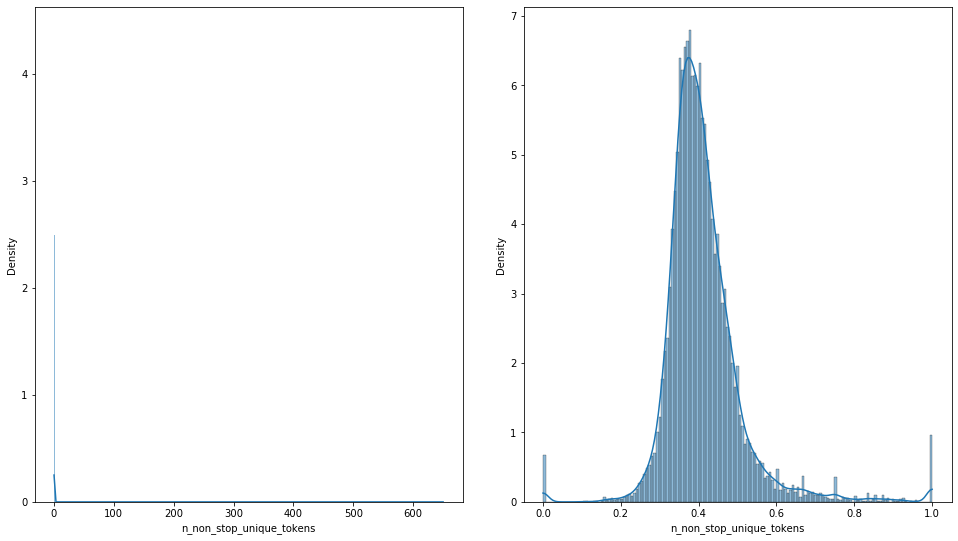

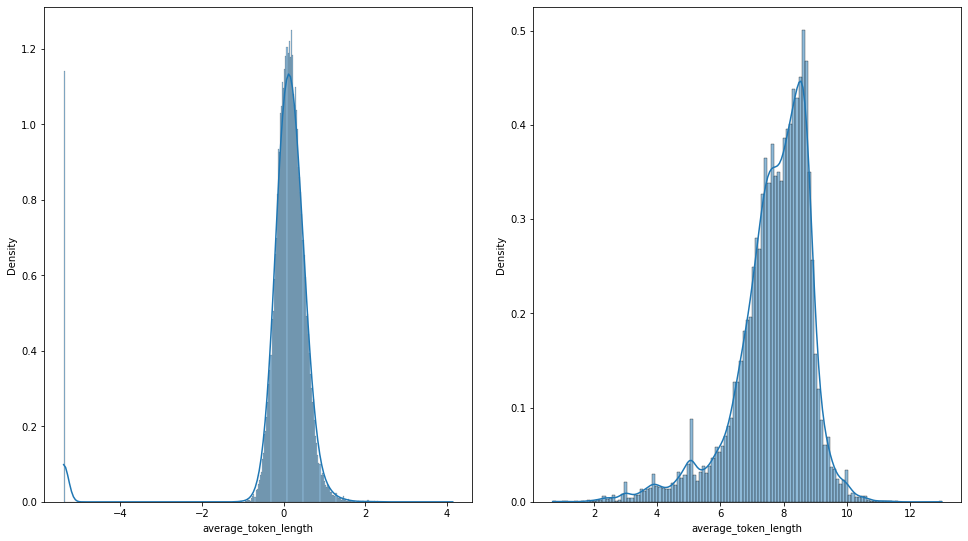

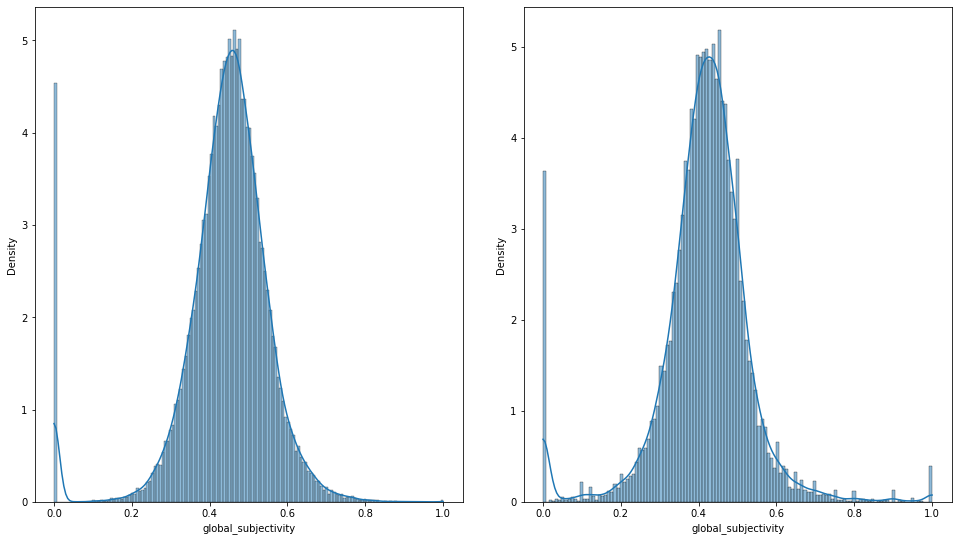

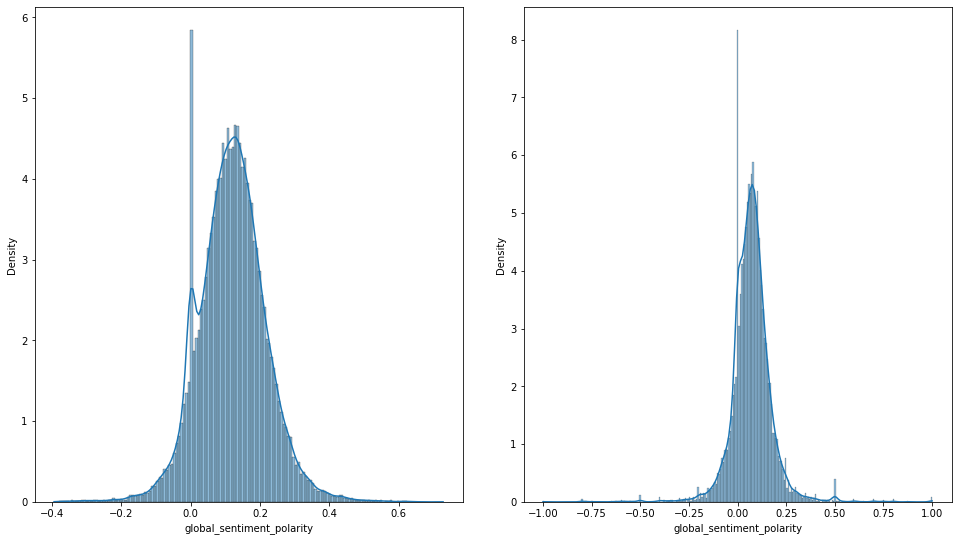

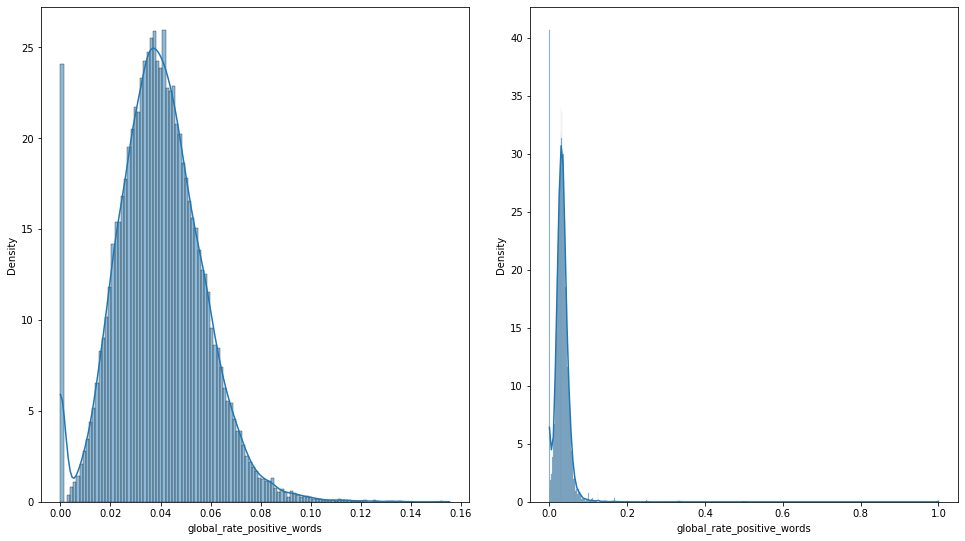

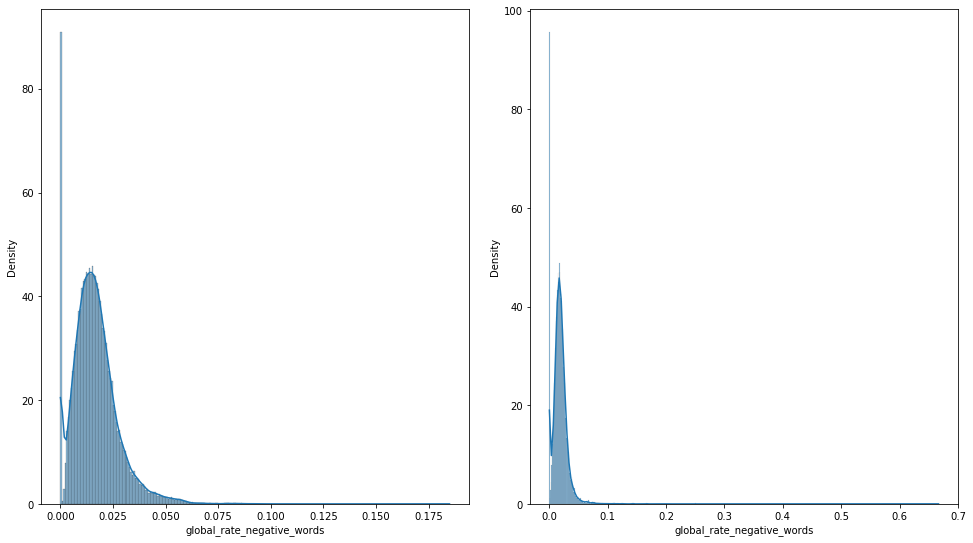

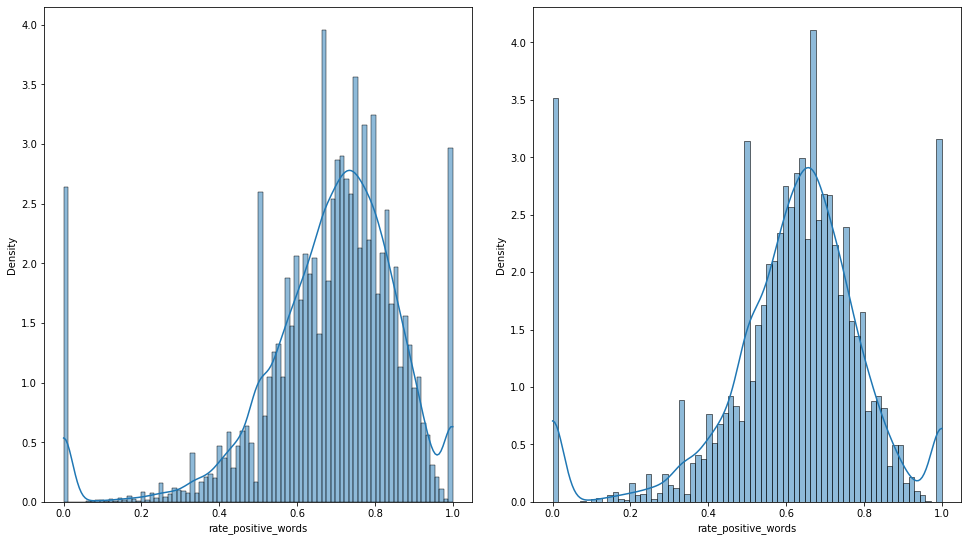

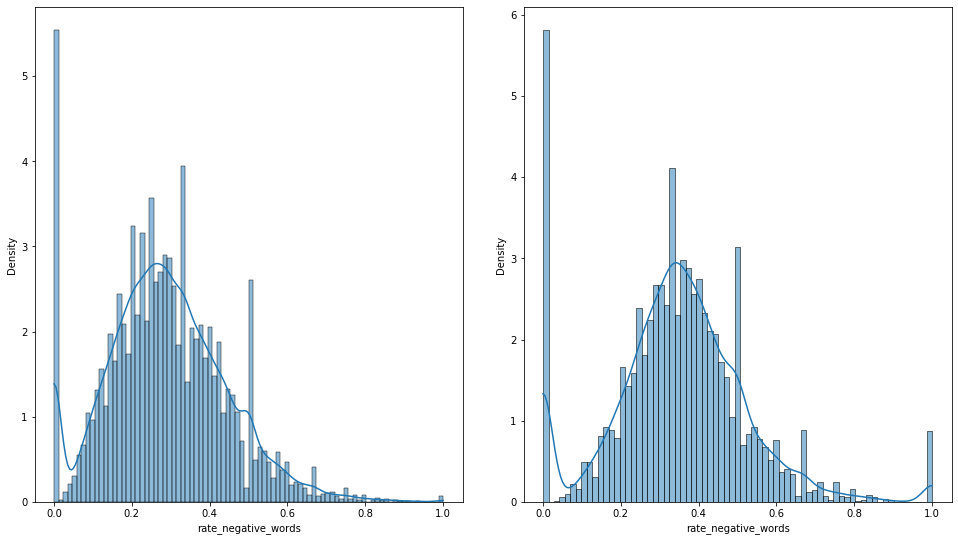

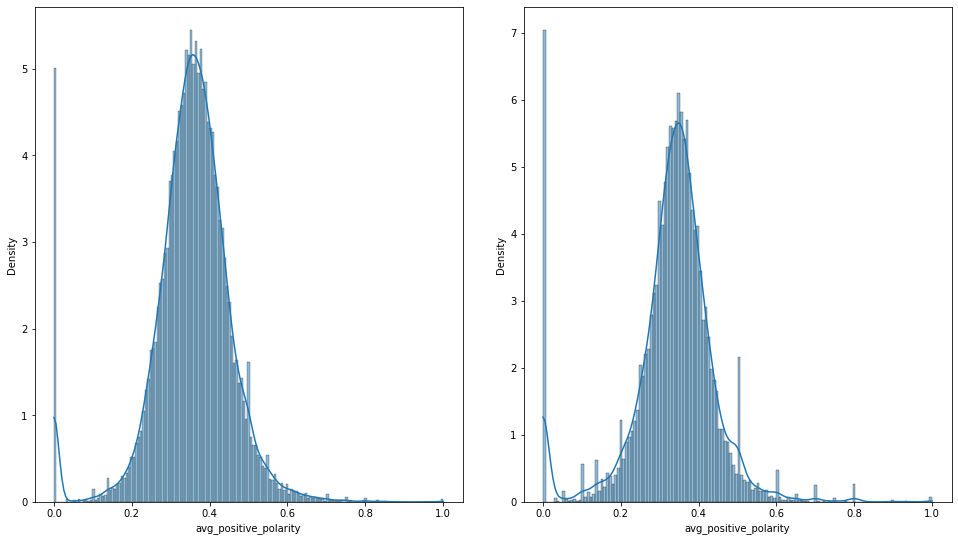

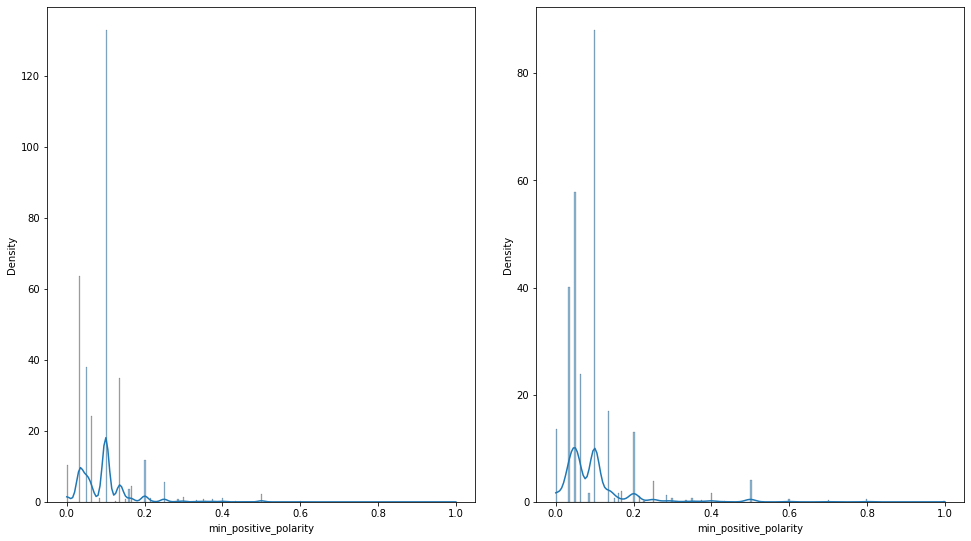

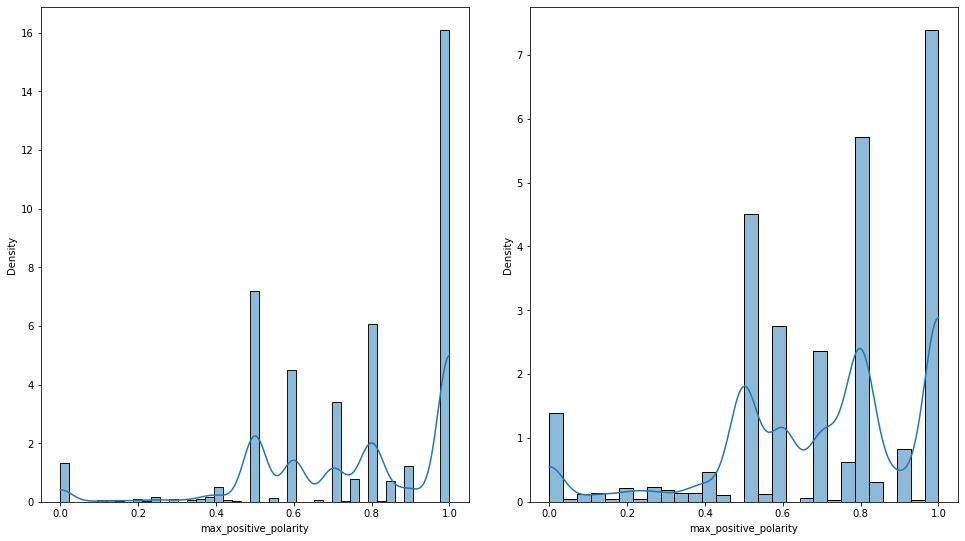

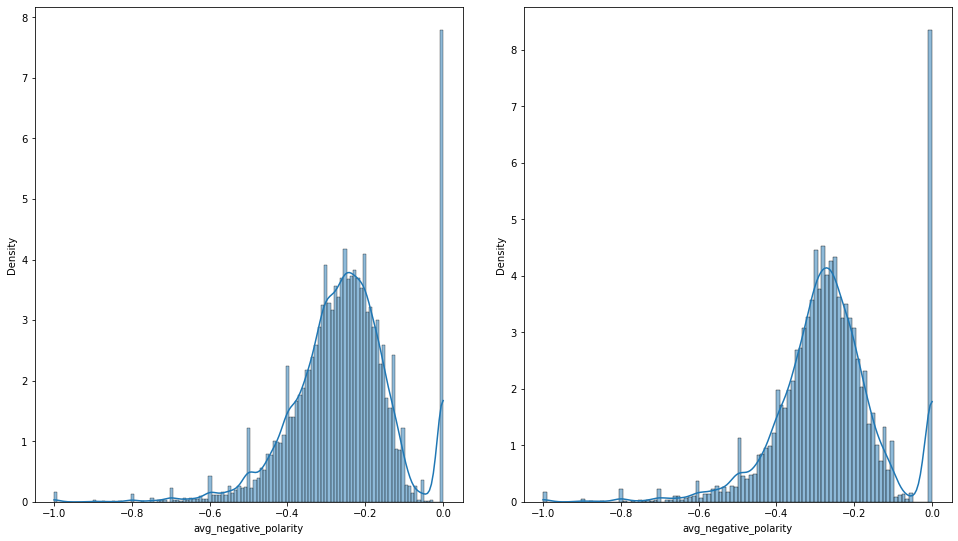

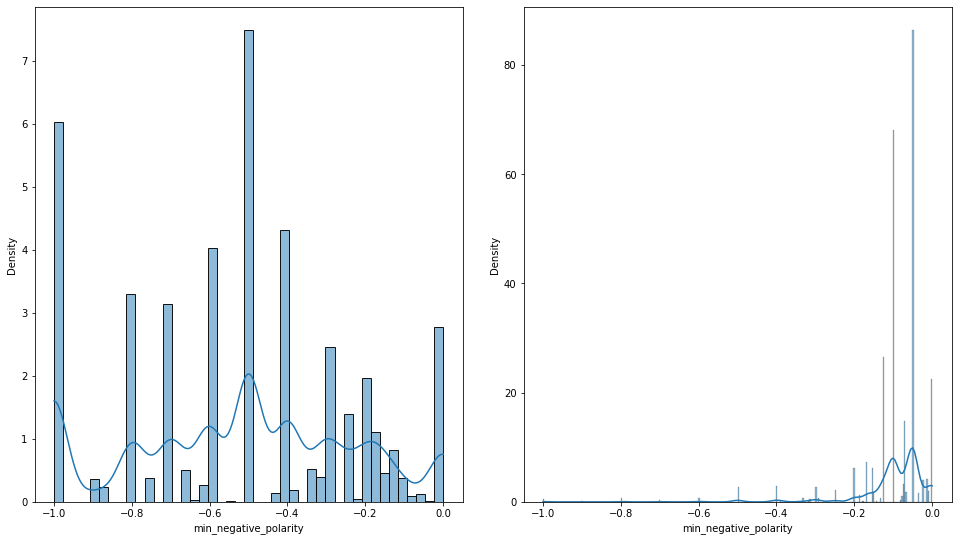

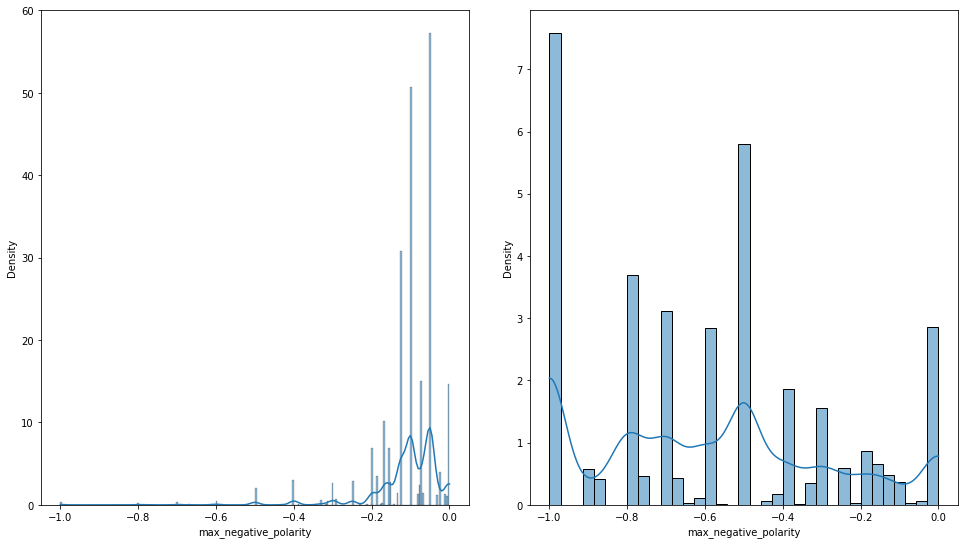

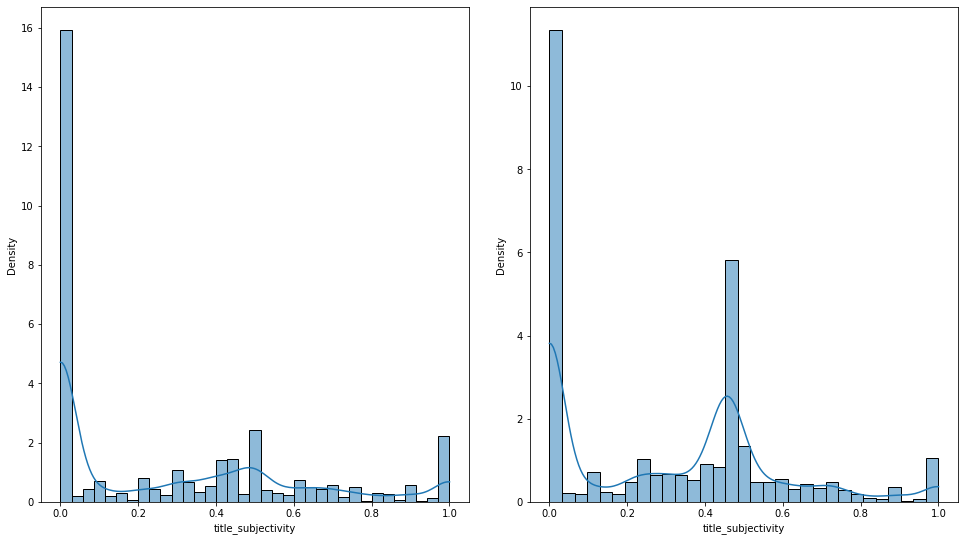

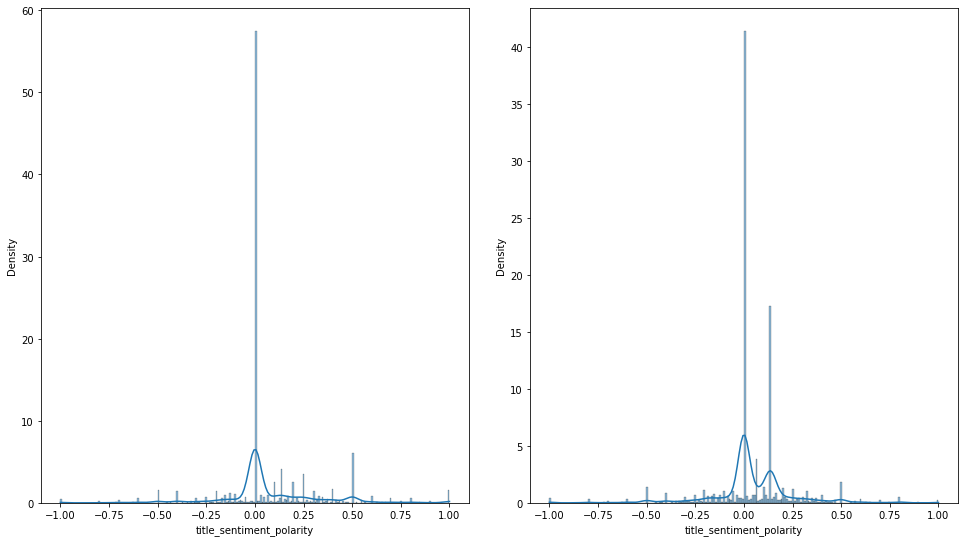

In [105]:
indices_list = list(range(0, 20))
indices_list.remove(3)

cols = np.array(data_kaggle_features.columns.tolist())[indices_list]
for (i, col) in zip(range(0, len(cols)), cols):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(14, 8)
    
    plt.tight_layout(pad=3.0)
    
    sns.histplot(data, x=col, stat='density', kde=True, ax=axes[0])
    sns.histplot(data_kaggle_features, x=col, stat='density', kde=True, ax=axes[1])  

#### Observation:
Some common features between the two datasets exhibit similar distribution. However, some features have a high disagreement between their distribution in the two datasets. The following two reasons can be attributed to the distribution disparity:

1. Outliers in both datasets
2. Lack of domain adaptation

***
## Comparing the two distributions using Jensen Shannon Divergence

In [277]:
def compute_divergence(dataframe1, dataframe2):
    indices_list = list(range(0, 20))
    indices_list.remove(3)

    print("\n-----------------------------------------------------\n\
    Jensen Shannon Distance between the two datasets\n-----------------------------------------------------\n")

    divergence_sum = 0
    
    cols = np.array(data_kaggle_features.columns.tolist())[indices_list]
    for (i, col) in zip(range(0, len(cols)), cols):
        data_uci_dist, data_bins = np.histogram(a=dataframe1[col], bins=10, density=True)
        data_kaggle_features_dist, data_kaggle_features_bins = np.histogram(a=dataframe2[col], bins=10, density=True)

        distance_val = distance.jensenshannon(data_uci_dist, data_kaggle_features_dist)
        divergence_sum = divergence_sum + distance_val

        if distance_val <= 0.5:
            print(colored('Feature ({}): {}\n'.format(col, distance_val), 'green'))
        elif distance_val > 0.5:
            print(colored('Feature ({}): {}\n'.format(col, distance_val), 'red'))
    
    print('****************************************\nAVERAGE DIVERGENCE: {}\n****************************************'.format(divergence_sum/19))

<a id='first-divergence'></a>

In [278]:
compute_divergence(data_uci, data_kaggle_features)


-----------------------------------------------------
    Jensen Shannon Distance between the two datasets
-----------------------------------------------------

Feature (n_tokens_title): 0.6066823608310755

Feature (n_tokens_content): 0.8146719868729811

Feature (n_unique_tokens): 0.8323180004835093

Feature (n_non_stop_unique_tokens): 0.8321774875300881

Feature (average_token_length): 0.3104415266734405

Feature (global_subjectivity): 0.13515206495412593

Feature (global_sentiment_polarity): 0.2915514402220241

Feature (global_rate_positive_words): 0.5680798699895298

Feature (global_rate_negative_words): 0.0935908079384363

Feature (rate_positive_words): 0.15736571873916835

Feature (rate_negative_words): 0.16655533748798454

Feature (avg_positive_polarity): 0.07567793381390954

Feature (min_positive_polarity): 0.0869927216172697

Feature (max_positive_polarity): 0.09407404317416629

Feature (avg_negative_polarity): 0.06923167619760996

Feature (min_negative_polarity): 0.615081187

#### Observation:
Here, the feature distances less than 0.5 represent the similar features and the feature distances greater than 0.5 represent the disparate features. So, as we can see, we have a lot of commonalities between the two domains. However, let's try to remove the outliers from both datasets using percentiles and observe if the outlier removal process improves the feature distribution similarity between the UCI and the Kaggle datasets.

***
## Outlier detection and removal

#### Outlier Detection

In [279]:
def boxplot_outlier_detection(dataframe, suptitle):
    indices_list = list(range(0, 20))

    cols = np.array(data_kaggle_features.columns.tolist())[indices_list]

    fig, axs = plt.subplots(4, 5)
    fig.set_size_inches(14, 10)

    plt.tight_layout(pad=0.3)
    fig.suptitle(suptitle, y=1.05, fontsize=18, fontweight=5)

    for j in range(0, 4):
        plt.tight_layout(pad=0.3)

        for i in range(0, 5):  
            plt.tight_layout(pad=0.3)
            index = (5*j) + i

            if index < 20:
                sns.boxplot(x=dataframe[cols[index]], ax=axs[j][i], flierprops = dict(markerfacecolor = '0.50', markersize = 2))

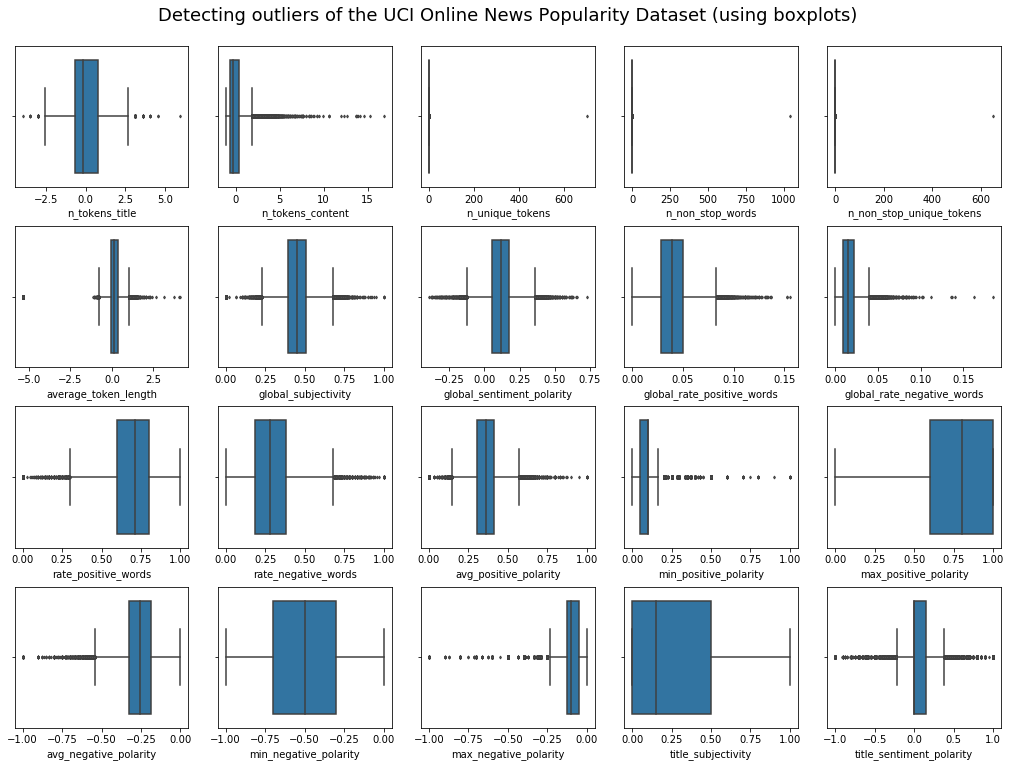

In [280]:
boxplot_outlier_detection(data_uci, "Detecting outliers of the UCI Online News Popularity Dataset (using boxplots)")

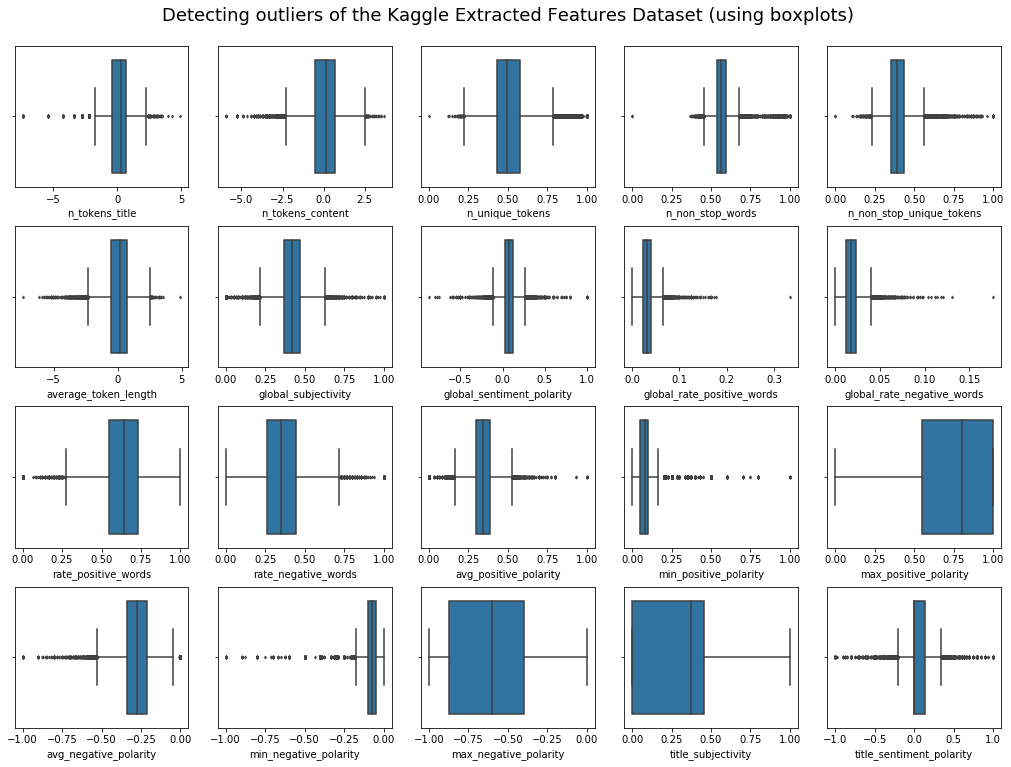

In [281]:
boxplot_outlier_detection(data_kaggle_features, "Detecting outliers of the Kaggle Extracted Features Dataset (using boxplots)")

#### Outlier Removal

From the boxplots above we can notice a lot of outliers in both the original UCI online news dataset and the Kaggle news extracted features dataset. Most of the outliers lie within the 0-10 percentile and 90-100 percentile. We can use thresholding and filter out the outliers from the dataframes. Before removing the outliers, let us check the length of the dataset so that we can verify if we are losing too many data points.

In [283]:
print('Length of UCI data: {}\n'.format(len(data_uci)))
print('Length of Kaggle extracted features: {}\n'.format(len(data_kaggle_features)))

Length of UCI data: 39644

Length of Kaggle extracted features: 18212



In [284]:
indices_list = list(range(0, 20))

cols = np.array(data_kaggle_features.columns.tolist())[indices_list]

minimum_threshold = 0.01
maximum_threshold = 0.99

for col in cols:
    data_uci = data_uci[(data_uci[col] >= data_uci[col].quantile(minimum_threshold)) & (data_uci[col] <= data_uci[col].quantile(maximum_threshold))]
    data_kaggle_features = data_kaggle_features[(data_kaggle_features[col] >= data_kaggle_features[col].quantile(minimum_threshold)) & (data_kaggle_features[col] <= data_kaggle_features[col].quantile(maximum_threshold))]

#### Validating Outlier Removal

Now let's check if we have been able to remove most of the outliers from the datasets using boxplots. At the same time, we will check how many data points we have left after the outlier removal.

In [285]:
print('Length of UCI data: {}\n'.format(len(data_uci)))
print('Length of Kaggle extracted features: {}\n'.format(len(data_kaggle_features)))

Length of UCI data: 33493

Length of Kaggle extracted features: 13767



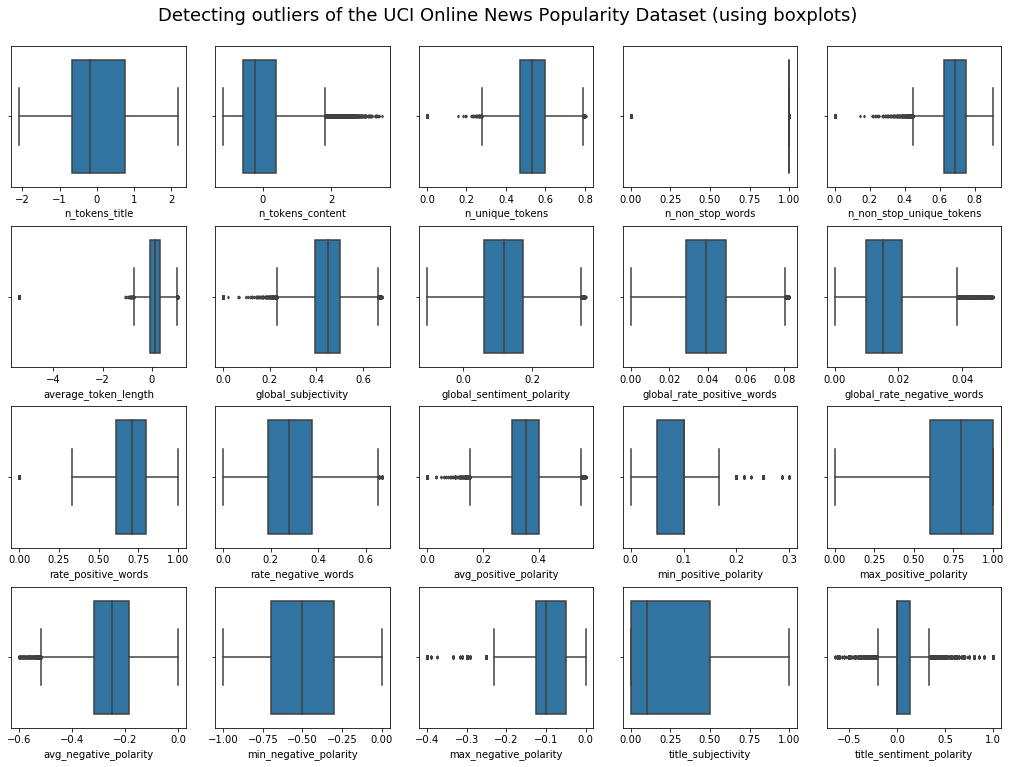

In [286]:
boxplot_outlier_detection(data_uci, "Detecting outliers of the UCI Online News Popularity Dataset (using boxplots)")

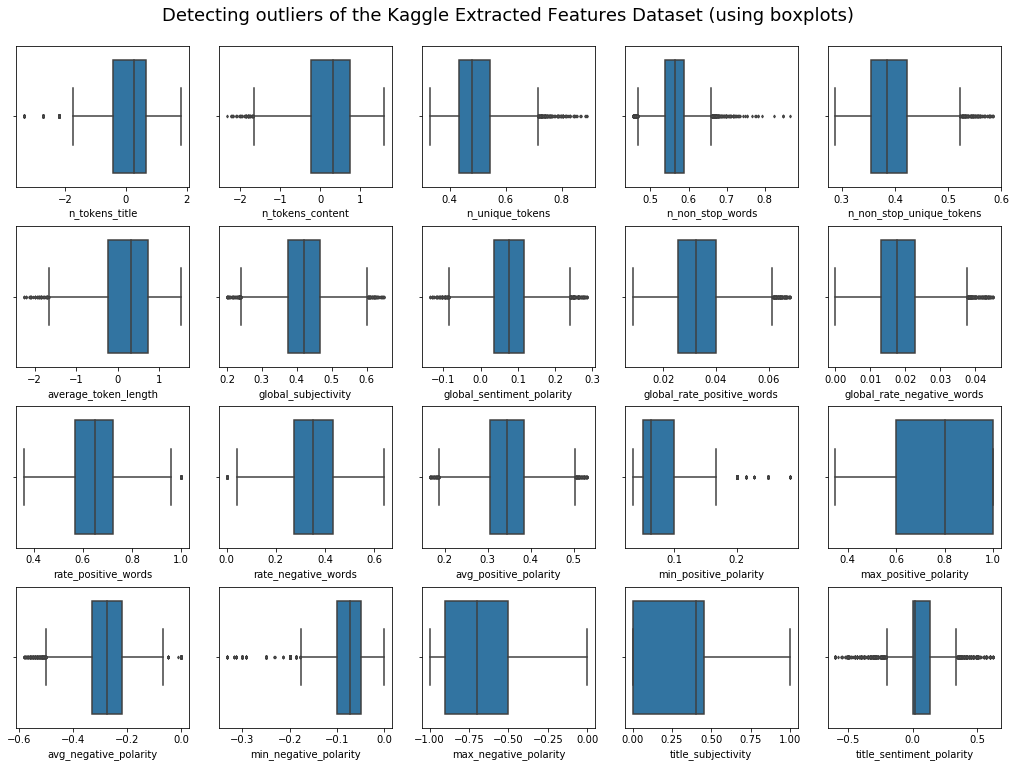

In [287]:
boxplot_outlier_detection(data_kaggle_features, "Detecting outliers of the Kaggle Extracted Features Dataset (using boxplots)")

### Observation:

We are removing the bottom 1% and the top 99-100% for improving outliers. However, we still have some distant values in the boxplots. But, accouting for those values needed more values to be dropped which is not feasible for the analysis. So, we keep the thresholds to 1% and 99%.

In [288]:
compute_divergence(data_uci, data_kaggle_features)


-----------------------------------------------------
    Jensen Shannon Distance between the two datasets
-----------------------------------------------------

Feature (n_tokens_title): 0.35561804167744354

Feature (n_tokens_content): 0.6241285121629865

Feature (n_unique_tokens): 0.6796666563693471

Feature (n_non_stop_unique_tokens): 0.6861022167550831

Feature (average_token_length): 0.5558329937042432

Feature (global_subjectivity): 0.4088155097332451

Feature (global_sentiment_polarity): 0.10146480066266177

Feature (global_rate_positive_words): 0.14212588106496368

Feature (global_rate_negative_words): 0.18287028905284203

Feature (rate_positive_words): 0.49057220947805397

Feature (rate_negative_words): 0.23829624888805956

Feature (avg_positive_polarity): 0.3159637182685474

Feature (min_positive_polarity): 0.560537619592716

Feature (max_positive_polarity): 0.38793716444753745

Feature (avg_negative_polarity): 0.14507920181990844

Feature (min_negative_polarity): 0.50023853

### Observation:

Counterintuitively, we find that the divergence exacerbates after outlier removal. However, the divergence that we had computed before the outlier removal using [Jensen Shannon Divergence](#first-divergence), ensured that some of the features had very low divergence and some had very high divergence. But, after outlier removal, all of the feature divergence moved towards 0.5 which we believe gives us a fair ground for all of the features and ensures that we don't have any bias.

***
## Regression Analysis with Domain Adaptation

Here, we will train a regression model on the source domain (UCI Online News Popularity Dataset) and test it on the target domain (Extracted features from the Kaggle Fake News Dataset). This domain adaptation falls under the broader category of transfer learning. In order for a model trained on the source domain to fit better on the target domain, we can perform domain adaptation through instance re-weighting. Since the regressor will be trained on the source domain, we want to re-weight the source instances. So, we will need a way to classify the source instances and the target instances. We will use a probabilistic classifier like logistic regression for getting the probabilities that an instance belongs to either the source or target domain. 

Then we can use the ratio of the source/target domain probabilities as a multiplier, we can re-weight all of the source instances and train the linear/non-linear regression model on the re-weighted source instances. Then, under the covariate shift assumption, we can say that the regressor will be adapted to the domain.

### Domain Adaptation

In [314]:
uci_domain = data_uci
kaggle_domain = data_kaggle_features

uci_domain['domain'] = 0
kaggle_domain['domain'] = 1

uci_kaggle_merged = pd.concat([uci_domain, kaggle_domain], join='inner')

In [315]:
log_reg = LogisticRegression()

X_train = uci_kaggle_merged.drop(['domain'], axis=1)
y_train = uci_kaggle_merged['domain']

log_reg.fit(X_train, y_train)

C:\Program Files\Python3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [316]:
def reweight(frame, cols):
    pt = log_reg.predict_proba([frame[cols].to_numpy()]).squeeze()[1]
    ps = log_reg.predict_proba([frame[cols].to_numpy()]).squeeze()[0]
    
    frame[cols] = (pt/ps) * frame[cols]
    
    return frame

In [317]:
indices_list = list(range(0, 20))
cols = np.array(data_kaggle_features.columns.tolist())[indices_list]

data_uci = data_uci.apply(reweight, args=(cols,), axis=1)

### Train Test Split

In [318]:
X = data_uci.drop(['shares'], axis=1)
y = data_uci['shares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [319]:
y_train = np.log(y_train + 0.0001)

### Linear Regression

In [320]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [321]:
y_pred = lin_reg.predict(X_test)

y_pred_inv = np.exp(y_pred)

In [322]:
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_inv)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_inv))))

MSE: 78474631.34124391
RMSE: 8858.5908214142


### Non-linear Regression

In [323]:
svr_reg = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=0.1).fit(X_train, y_train)

In [324]:
y_pred = svr_reg.predict(X_test)

y_pred_inv = np.exp(y_pred)

In [325]:
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_inv)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_inv))))

MSE: 79386587.44485858
RMSE: 8909.915119958134


#### Testing on the target domain (extracted features from Kaggle Fake News Dataset):

In [336]:
kaggle_data_to_be_predicted = data_kaggle_features.iloc[5000]

kaggle_data_to_be_predicted.loc['num_imgs'] = np.log(3)
kaggle_data_to_be_predicted.loc['num_videos'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_monday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_tuesday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_wednesday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_thursday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_friday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_saturday'] = 0
kaggle_data_to_be_predicted.loc['weekday_is_sunday'] = 1.0

C:\Program Files\Python3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [337]:
kaggle_predicted_shares = svr_reg.predict([kaggle_data_to_be_predicted])

print(np.exp(kaggle_predicted_shares))

[2429.61708942]


### References

[1] <a id='1-paper'></a> K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the  Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

[2] <a id='2-paper'></a> Transfer learning: domain adaptation by instance-reweighting - https://johanndejong.wordpress.com/2017/10/15/transfer-learning-domain-adaptation-by-instance-reweighting/

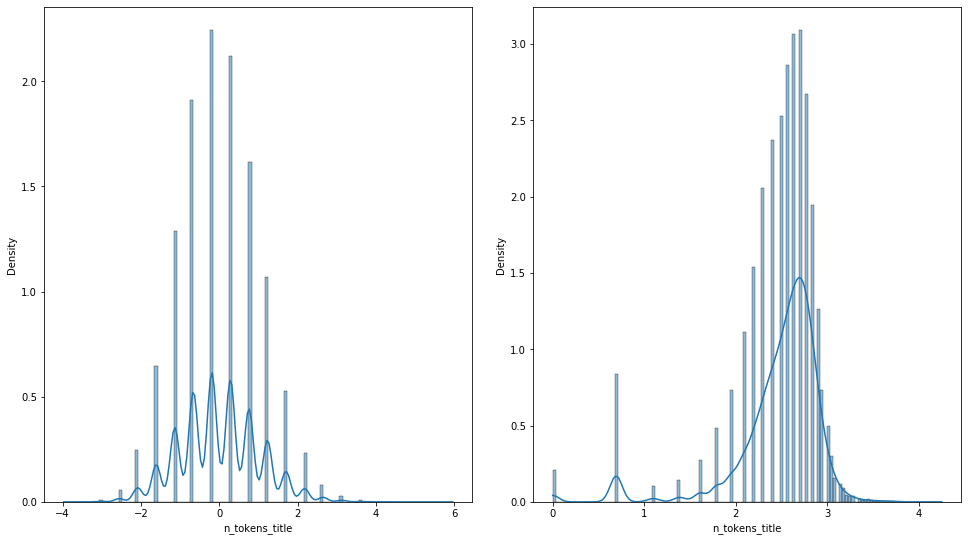

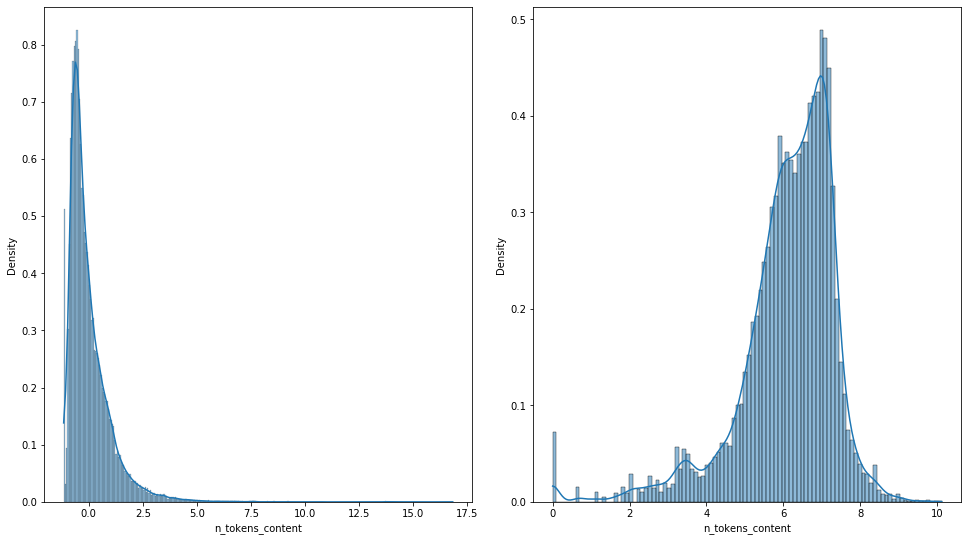

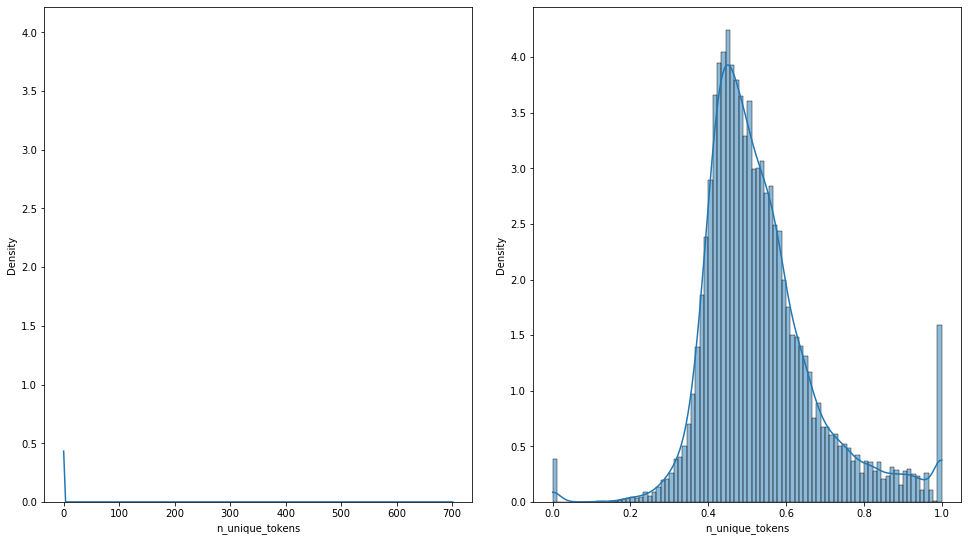

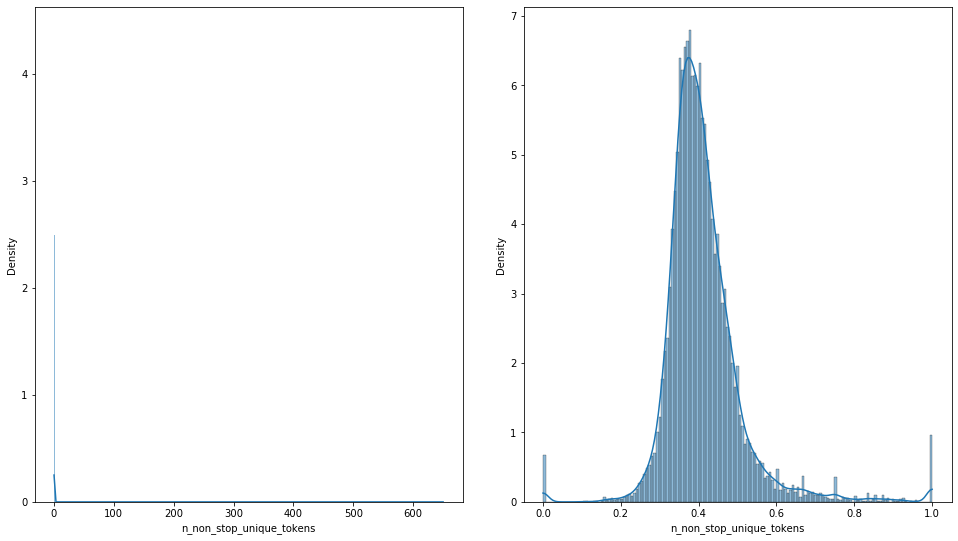

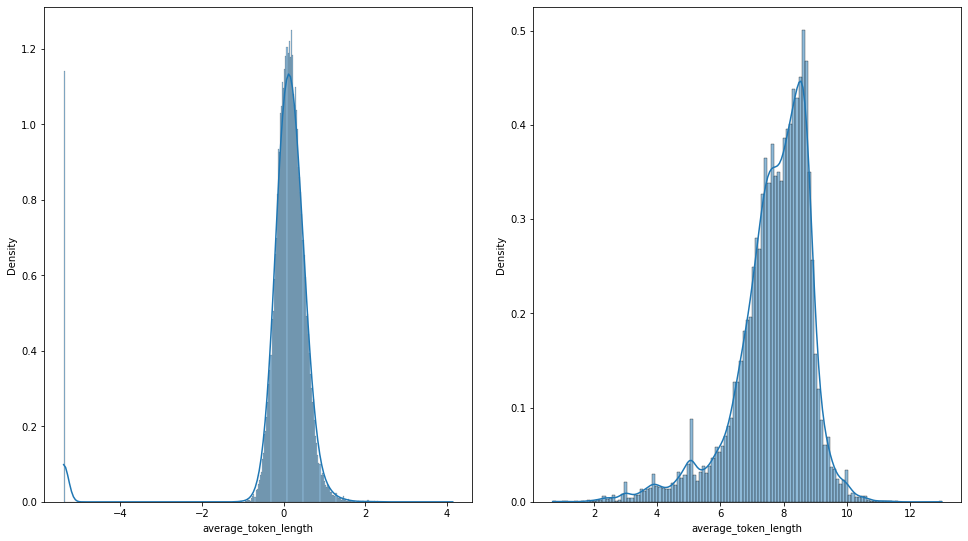

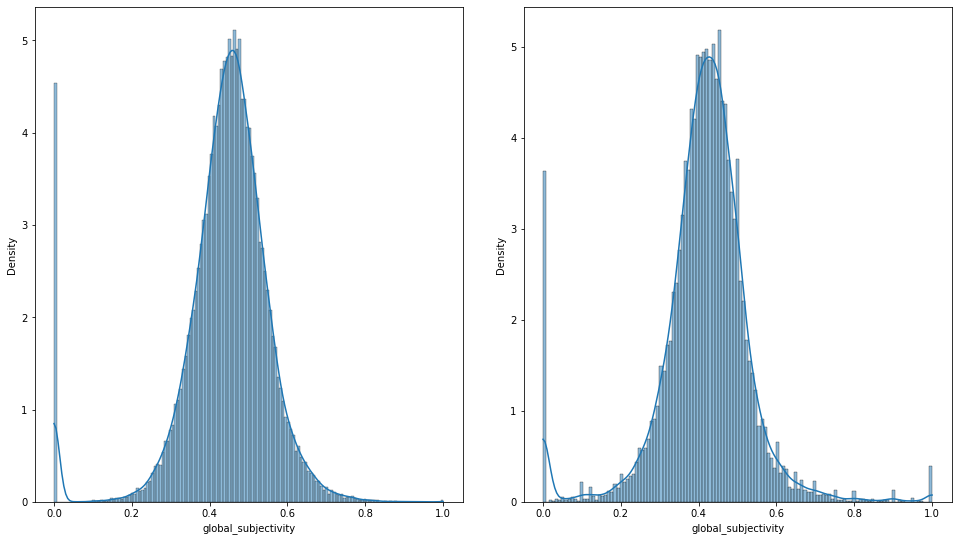

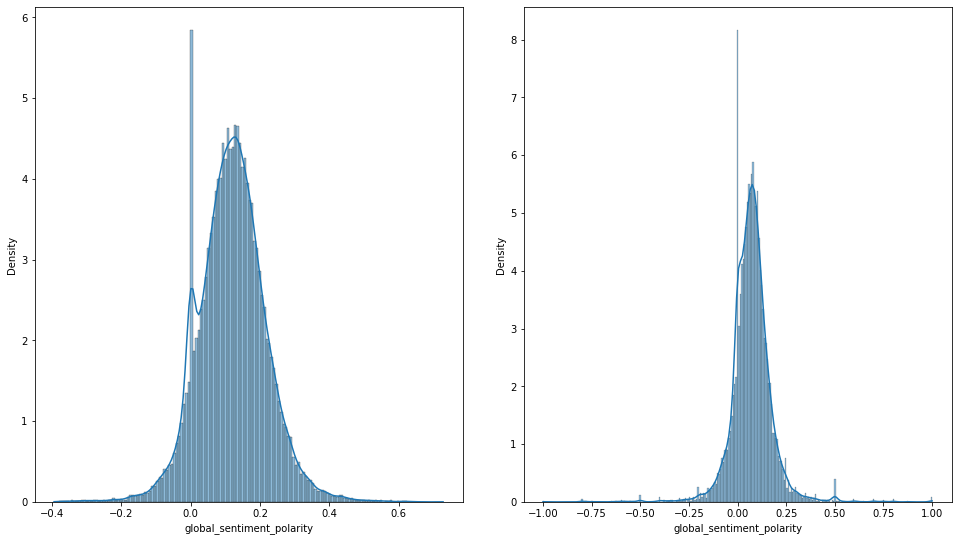

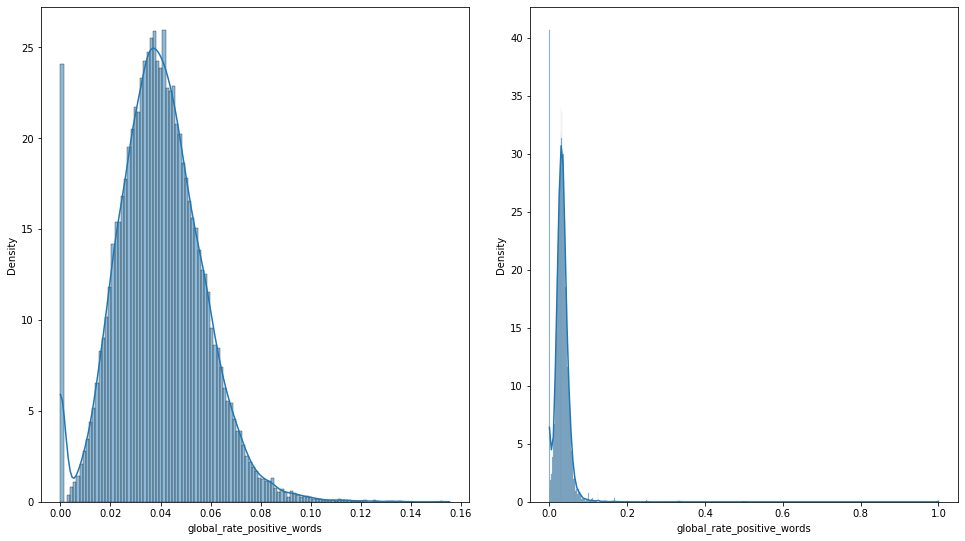

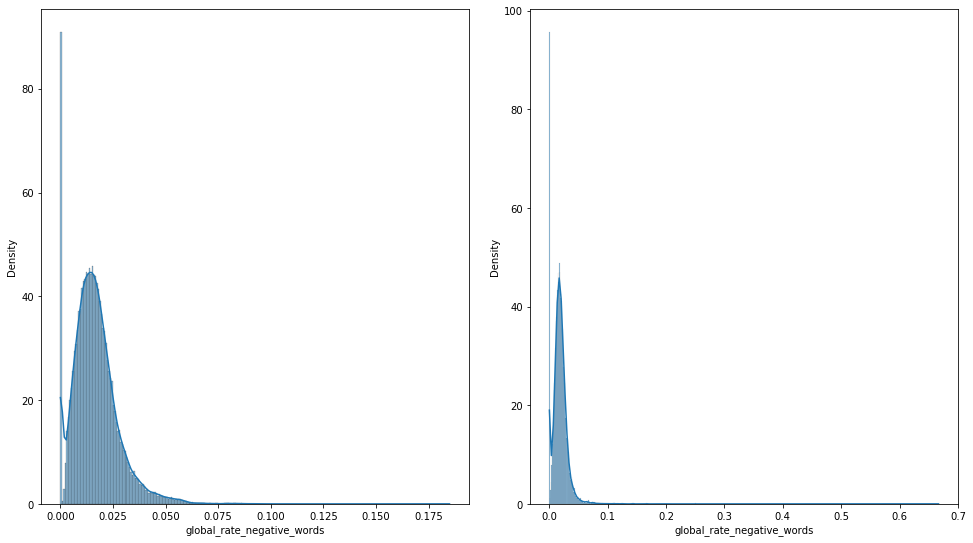

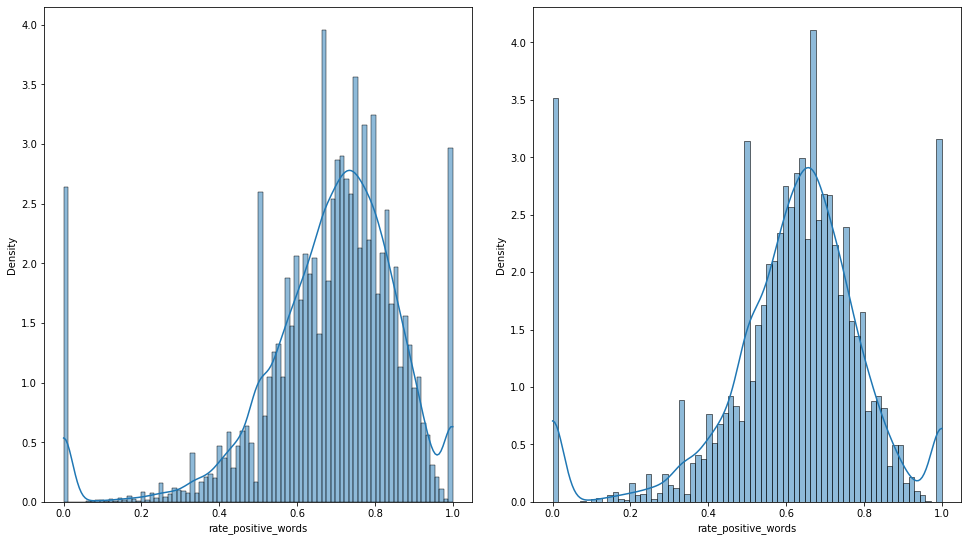

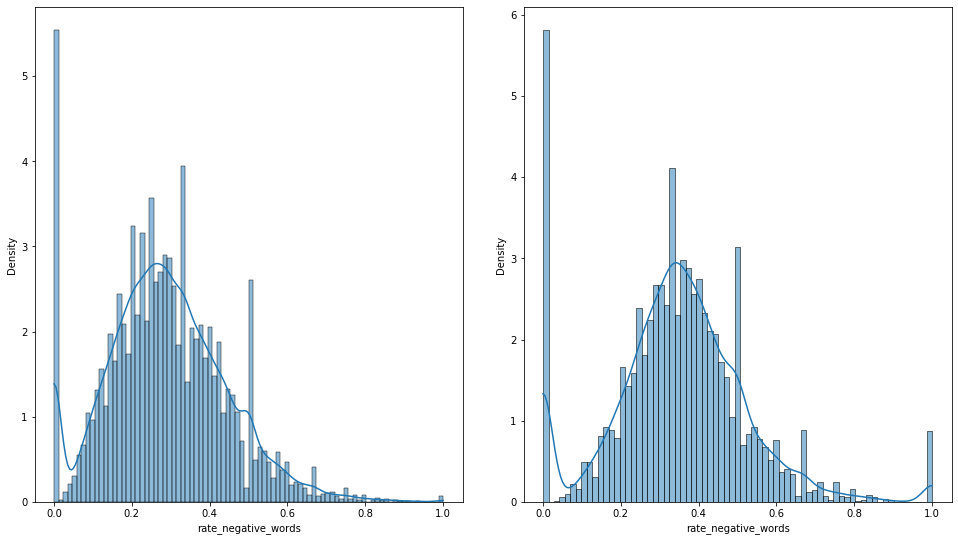

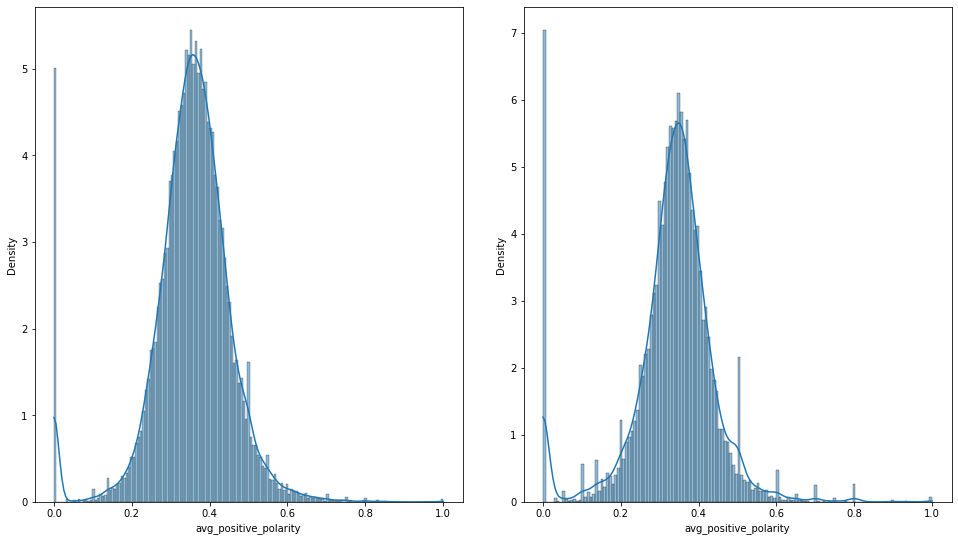

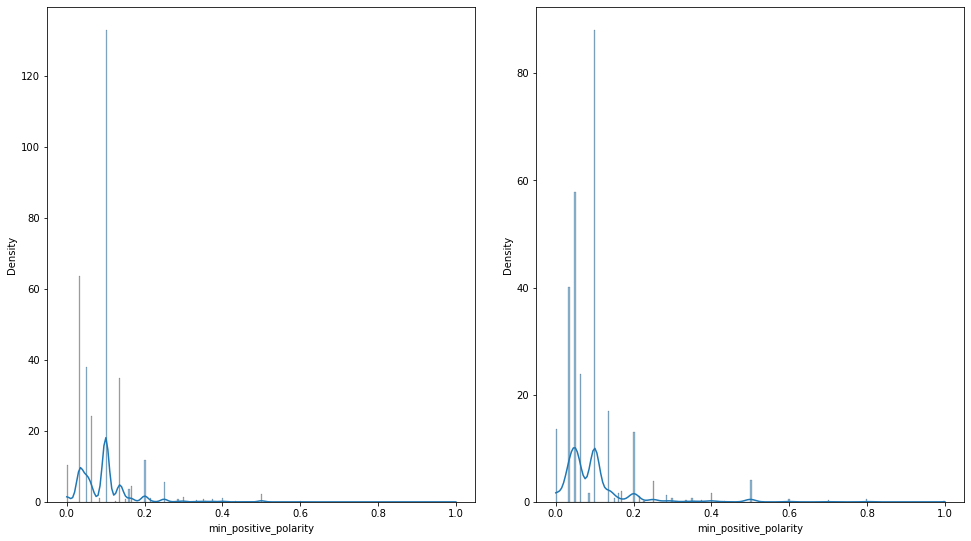

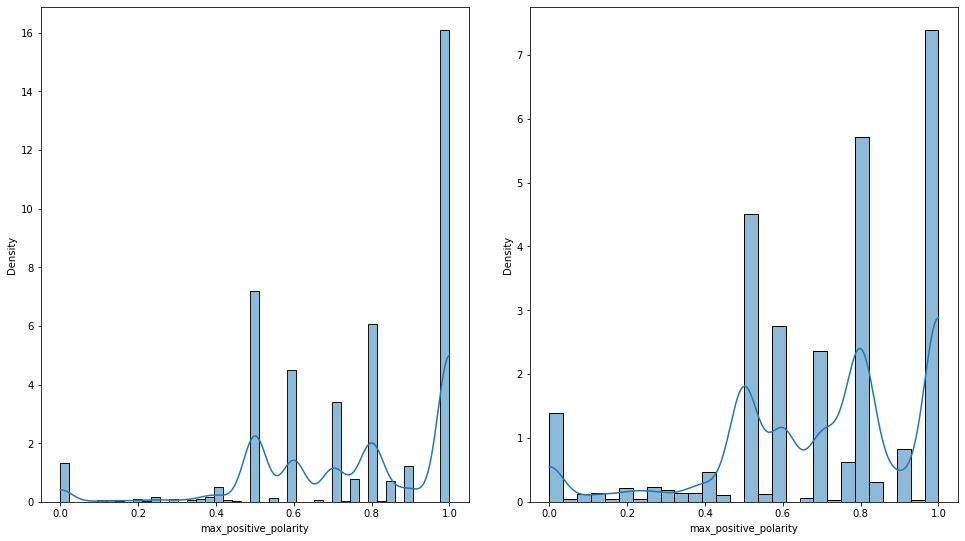

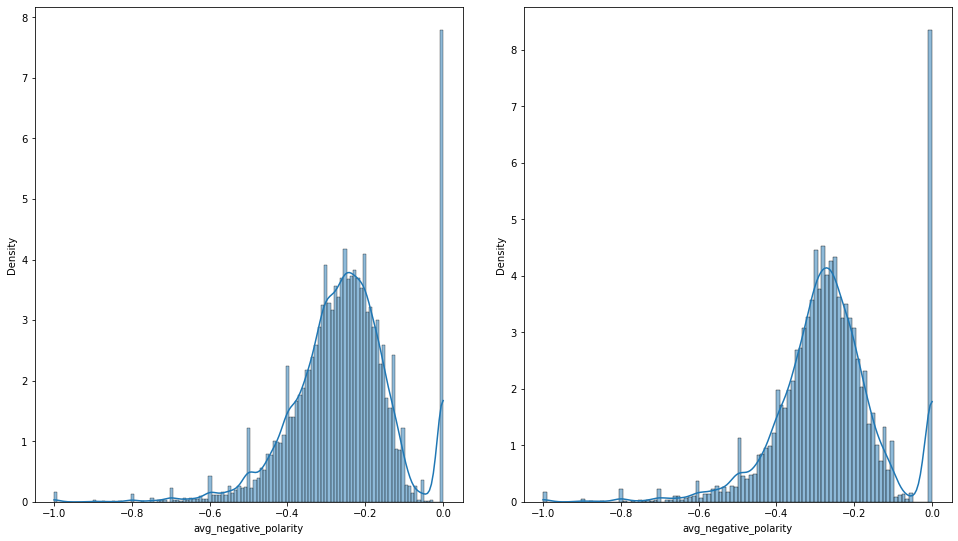

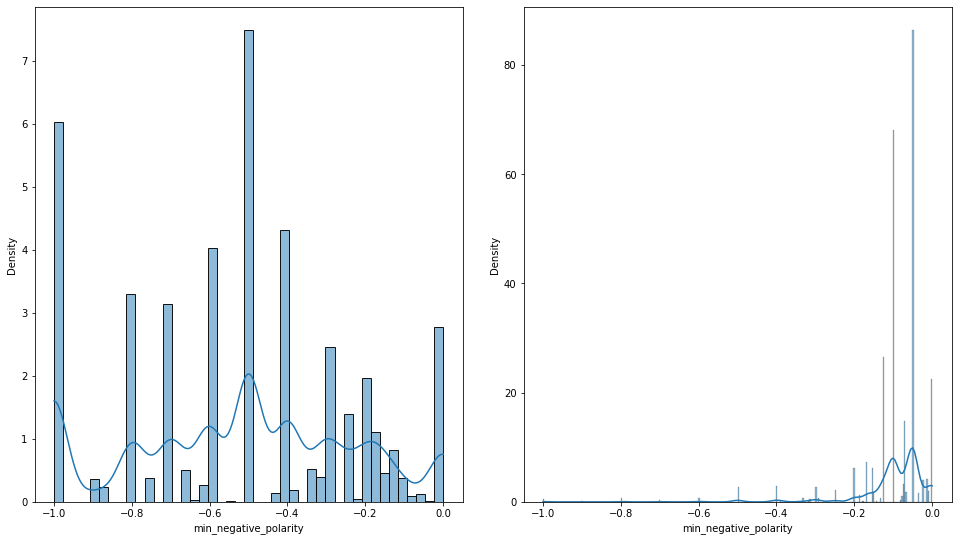

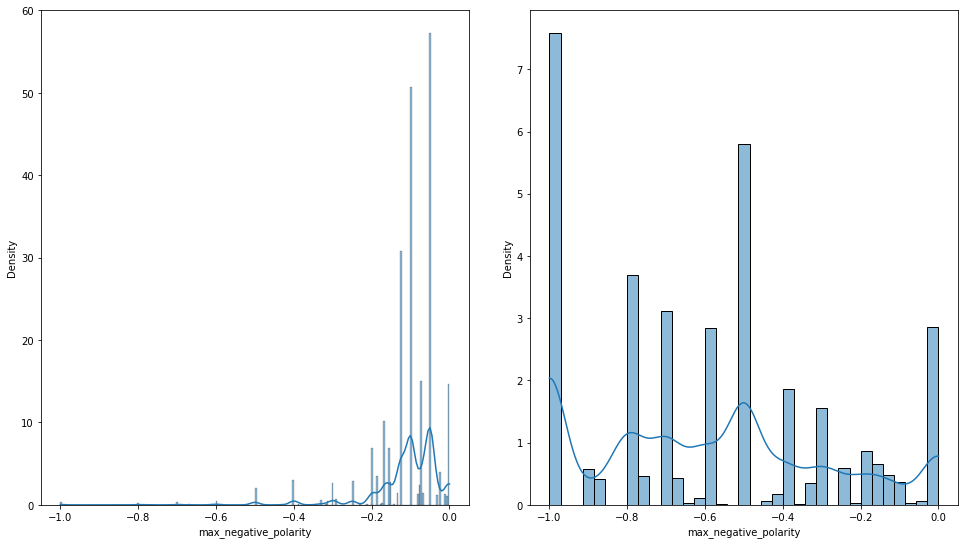

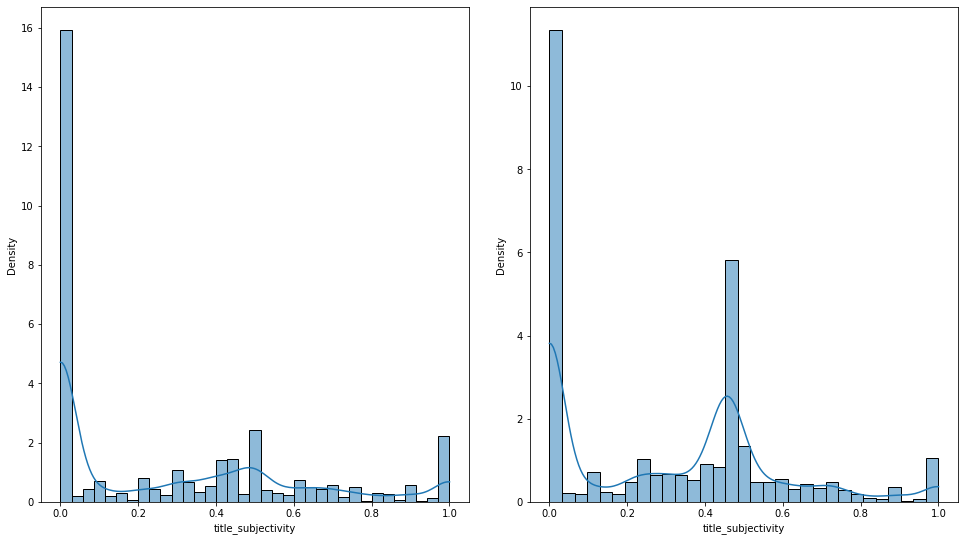

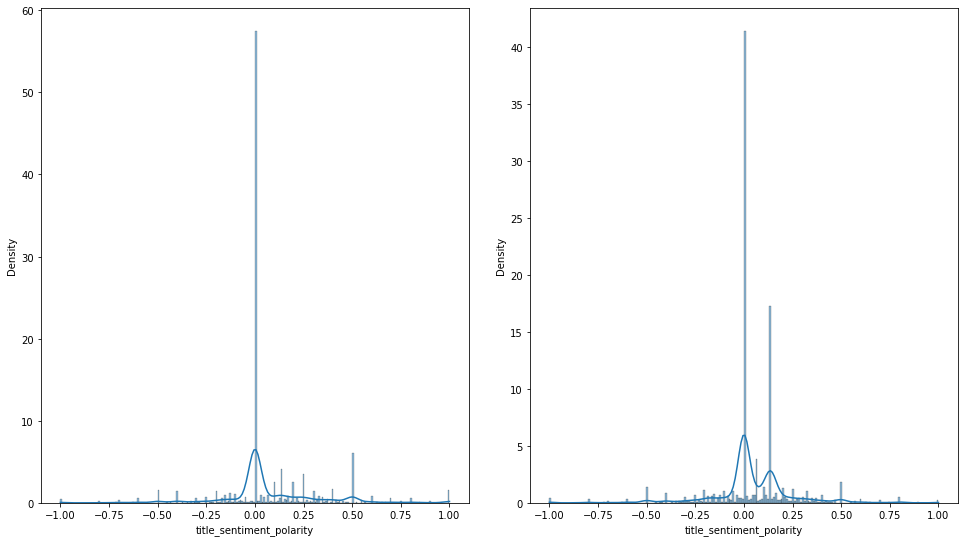

In [105]:
# indices_list = list(range(0, 20))
# indices_list.remove(3)

# cols = np.array(data_kaggle_features.columns.tolist())[indices_list]
# for (i, col) in zip(range(0, len(cols)), cols):
#     fig, axes = plt.subplots(1, 2)
#     fig.set_size_inches(14, 8)
    
#     plt.tight_layout(pad=3.0)
    
#     sns.histplot(data, x=col, stat='density', kde=True, ax=axes[0])
#     sns.histplot(data_kaggle_features, x=col, stat='density', kde=True, ax=axes[1])  